In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

In [2]:
dataset_path = 'augmented_faces'
img_height, img_width = 224, 224
batch_size = 32

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
   validation_split=0.2,
   rotation_range=40,
   width_shift_range=0.4,
   height_shift_range=0.4,
   shear_range=0.4,
   zoom_range=0.4,
   horizontal_flip=True,
   fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2060 images belonging to 31 classes.
Found 502 images belonging to 31 classes.


In [4]:
base_model = VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = True 

In [5]:
fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [6]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])


In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [9]:
print(train_data.class_indices)  # Check class labels
print(train_data.samples)       # Number of training samples
print(val_data.samples)         # Number of validation samples


{'Akshay Kumar': 0, 'Alexandra Daddario': 1, 'Alia Bhatt': 2, 'Amitabh Bachchan': 3, 'Andy Samberg': 4, 'Anushka Sharma': 5, 'Billie Eilish': 6, 'Brad Pitt': 7, 'Camila Cabello': 8, 'Charlize Theron': 9, 'Claire Holt': 10, 'Courtney Cox': 11, 'Dwayne Johnson': 12, 'Elizabeth Olsen': 13, 'Ellen Degeneres': 14, 'Henry Cavill': 15, 'Hrithik Roshan': 16, 'Hugh Jackman': 17, 'Jessica Alba': 18, 'Kashyap': 19, 'Lisa Kudrow': 20, 'Margot Robbie': 21, 'Marmik': 22, 'Natalie Portman': 23, 'Priyanka Chopra': 24, 'Robert Downey Jr': 25, 'Roger Federer': 26, 'Tom Cruise': 27, 'Vijay Deverakonda': 28, 'Virat Kohli': 29, 'Zac Efron': 30}
2060
502


In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/60


c:\Users\adity\Desktop\Face\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.0429 - loss: 5.6056 - val_accuracy: 0.0518 - val_loss: 4.8484 - learning_rate: 1.0000e-04
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.0679 - loss: 5.1278 - val_accuracy: 0.0498 - val_loss: 5.2479 - learning_rate: 1.0000e-04
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.1045 - loss: 4.6531 - val_accuracy: 0.0398 - val_loss: 5.3818 - learning_rate: 1.0000e-04
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.1221 - loss: 4.4334 - val_accuracy: 0.0657 - val_loss: 5.2885 - learning_rate: 1.0000e-04
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.1483 - loss: 4.1640 - val_accuracy: 0.1853 - val_loss: 3.7841 - learning_rate: 1.0000e-04
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.2011 - loss: 3.8231 - val_accuracy: 0.1633 - val_loss: 3.9855 - learning_rate: 1.0000e-04
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.2364 - loss: 3.6

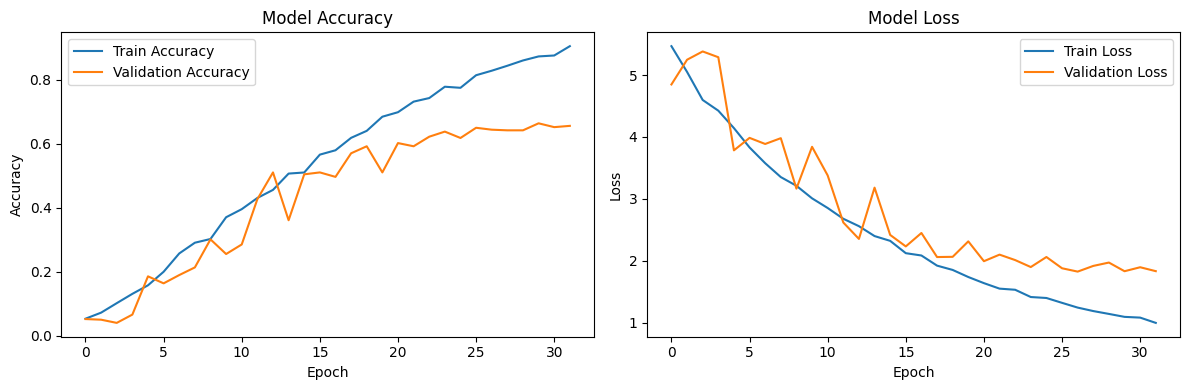

In [11]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()